# ISLR Chapter 7 - Moving Beyond Linearity

## Lab Exercises 

* [Lab 8.3.1 Fitting Classification Trees](#lab_8.3.1) [(JRouser lab)](#jr_class)

* [Lab 8.3.2 Fitting Regression Trees](#lab_8.3.2) [(JRouser lab)](#jr_regressi)

* [Lab 8.3.3 Bagging and Random Forests](#lab_8.3.3) [(JRouser lab)](#jr_bagging)

* [Lab 8.3.4 Boosting](#lab_8.3.4) [(JRouser lab)](#jr_boosting)


## [Conceptual Exercises](#concept)

In [14]:
'''
references:
JWarmenhoven: https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/
collinprather: https://github.com/collinprather/ISLR-Python
Jliu: https://github.com/0liu/ISLR

http://www.science.smith.edu/~jcrouser/SDS293/labs/lab12-py.html
http://www.science.smith.edu/~jcrouser/SDS293/labs/lab13-py.html
'''

# Standard libraries
import time
import warnings

# Math and data processing
import numpy as np
import scipy as sp
import pandas as pd

# StatsModels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from patsy import dmatrix

# scikit-learn
from sklearn.preprocessing import PolynomialFeatures

# Visulization
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')

In [6]:
wage = pd.read_csv('Wage.csv', index_col = 0)
wage

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
376816,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
302281,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
10033,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
14375,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [7]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 231655 to 453557
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   maritl      3000 non-null   object 
 3   race        3000 non-null   object 
 4   education   3000 non-null   object 
 5   region      3000 non-null   object 
 6   jobclass    3000 non-null   object 
 7   health      3000 non-null   object 
 8   health_ins  3000 non-null   object 
 9   logwage     3000 non-null   float64
 10  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 281.2+ KB


In [9]:
def ortho_poly_fit(x, degree = 1):
    '''
    Utility function to convert data into orthogonal basis for polynomial regression by QR decomposition.
    Ref: http://davmre.github.io/python/2013/12/15/orthogonal_poly
    '''
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
            stop("'degree' must be less than number of unique points")
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q,r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)

    norm2 = np.sum(raw**2, axis=0)
    alpha = (np.sum((raw**2)*np.reshape(x,(-1,1)), axis=0)/norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z, norm2, alpha

<a id='lab_7.8.1'></a>
## Lab 7.8.1 Polynomial Regression and Step Functions

### JLiu method (based on JRouser lab but less explanations)
Polynomial regression of degree 4 on orthogonalized X

In [10]:
# Polynomial regression of degree 4 on orthogonalized X. Refer to chapter 3 notebook.
X4_ortho = ortho_poly_fit(wage[['age']], degree=4)[0]
X4_ortho[:,0]=1  # Replace constant (first) column with 1s for Intercept estimation.
poly4_ortho = sm.GLS(wage['wage'], X4_ortho).fit()
print(poly4_ortho.summary())

                            GLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            GLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Sat, 16 May 2020   Prob (F-statistic):           2.77e-57
Time:                        17:15:47   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.7036      0.729    153.283      0.0

**Polynomial regression of degree 4 on raw X without orthogonalization.**

In [11]:
# Polynomial regression of degree 4 on raw X without orthogonalization.
X4 = PolynomialFeatures(degree=4).fit_transform(wage[['age']])
poly4 = sm.GLS(wage['wage'], X4).fit()
print(poly4.summary())

                            GLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            GLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Sat, 16 May 2020   Prob (F-statistic):           2.77e-57
Time:                        17:16:36   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.0

**Predict over a grid of age.**

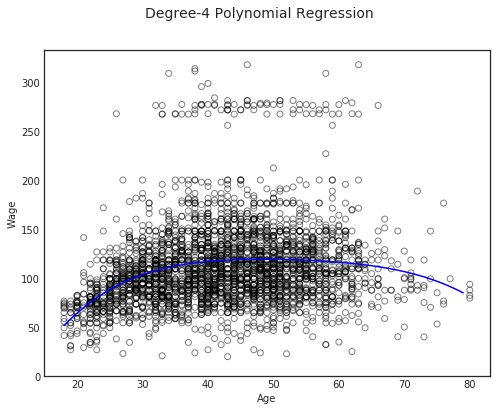

In [12]:

# Generate a sequence of age values spanning the range
age_grid = np.arange(wage.age.min(), wage.age.max()).reshape(-1,1)

# Generate test data
X_test = PolynomialFeatures(4).fit_transform(age_grid)

# Predict the value of the generated ages
y_pred = poly4.predict(X_test)

# Plot
fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle('Degree-4 Polynomial Regression', fontsize=14)

# Scatter plot with polynomial regression line
plt.scatter(wage.age, wage.wage, facecolor='None', edgecolor='k', alpha=0.5)
plt.plot(age_grid, y_pred, color = 'b')
ax.set_ylim(ymin=0)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.show()

**ANOVA on polynomial regression of degree from 1 to 5.**

In [15]:
# Polynomial regression of degree 1,2,3,5
X1 = PolynomialFeatures(degree=1).fit_transform(wage[['age']])
X2 = PolynomialFeatures(degree=2).fit_transform(wage[['age']])
X3 = PolynomialFeatures(degree=3).fit_transform(wage[['age']])
X5 = PolynomialFeatures(degree=5).fit_transform(wage[['age']])
poly1 = sm.GLS(wage['wage'], X1).fit()
poly2 = sm.GLS(wage['wage'], X2).fit()
poly3 = sm.GLS(wage['wage'], X3).fit()
poly5 = sm.GLS(wage['wage'], X5).fit()
# ANOVA, as in chpater 3 notebook
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")  ## Supress warnings
    display(anova_lm(poly1, poly2, poly3, poly4, poly5))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


The p-value comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is approximately 5% while the degree-5 polynomial Model 5 seems unnecessary because its p-value is 0.37. Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, but lower- or higher-order models are not justified.

In [16]:
# Polynomial regression of degree 5 on orthogonalized X. Refer to chapter 3 notebook.
X5_ortho = ortho_poly_fit(wage[['age']], degree=5)[0]
X5_ortho[:,0]=1  # Replace constant column with 1s for Intercept estimation.
poly5_ortho = sm.GLS(wage['wage'], X5_ortho).fit()
print(poly5_ortho.summary())

                            GLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.087
Model:                            GLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     56.71
Date:                Sat, 16 May 2020   Prob (F-statistic):           1.67e-56
Time:                        17:20:20   Log-Likelihood:                -15314.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2994   BIC:                         3.068e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.7036      0.729    153.278      0.0

**Classification: wage > $250,000 per year?**

In [17]:
# Create binary qualitative response
y_clf = (wage.wage > 250).map({False:0, True:1})
# Logistic regression
logreg = sm.GLM(y_clf, X4, family=sm.families.Binomial()).fit() #use degree 4
print(logreg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Sat, 16 May 2020   Deviance:                       701.22
Time:                        17:20:51   Pearson chi2:                 3.70e+03
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.5530     47.655     -2.299      0.0

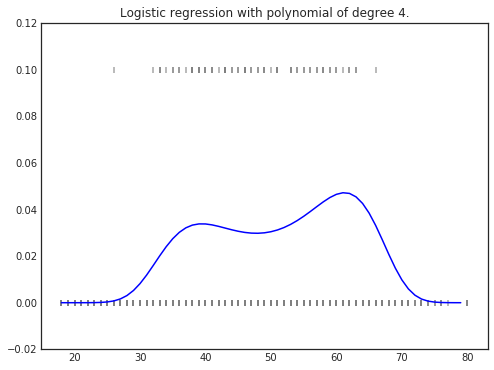

In [18]:
# Predict on age grid
y_pred_clf = logreg.predict(X_test)
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(age_grid, y_pred_clf, color='b')
plt.ylim(-0.02, 0.12)

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax.scatter(wage.age, y_clf/10, s=30, c='grey', marker='|', alpha=0.7)
plt.title("Logistic regression with polynomial of degree 4.")
plt.show()

**Step functions for piecewise-constant regression**

In [19]:
# Cut predictor data into intervals of a step function
wage_cut, bins = pd.cut(wage.age, 4, retbins=True, right=True)
wage_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [20]:
# Create dummies for predictor intervals
wage_step_dummies = pd.get_dummies(wage_cut, drop_first=True)  # The first interval is the base and dropped
wage_step_dummies = pd.DataFrame(sm.add_constant(wage_step_dummies.values), columns=['(Intercept)'] + list(wage_step_dummies.columns.values), index=wage_step_dummies.index)
wage_step_dummies.head(25)

,(Intercept),"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
231655,1.0,0.0,0.0,0.0
86582,1.0,0.0,0.0,0.0
161300,1.0,1.0,0.0,0.0
155159,1.0,1.0,0.0,0.0
11443,1.0,0.0,1.0,0.0
376662,1.0,0.0,1.0,0.0
450601,1.0,1.0,0.0,0.0
377954,1.0,0.0,0.0,0.0
228963,1.0,1.0,0.0,0.0
81404,1.0,0.0,1.0,0.0


In [21]:
# Piecewise-constant regression as a step function
logreg_step = sm.GLM(wage.wage, wage_step_dummies).fit()
print(logreg_step.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1634.1
Method:                          IRLS   Log-Likelihood:                -15353.
Date:                Sat, 16 May 2020   Deviance:                   4.8957e+06
Time:                        17:22:32   Pearson chi2:                 4.90e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
(Intercept)     94.1584      1.476     63.790   

<a id='jr_poly'></a>
## JRouser Polynomial Regression and Step Functions (The original lab)

In [27]:
df = pd.read_csv('Wage.csv', index_col= 0)
df.head(3)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


First fit the polynomial regression model using the following commands:

In [32]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

This syntax fits a linear model, using the PolynomialFeatures() function, in order to predict wage using up to a fourth-degree polynomial in age. The PolynomialFeatures() command allows us to avoid having to write out a long formula with powers of age. We can then fit our linear model:

In [33]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


Next we consider the task of predicting whether an individual earns more than $250,000 per year. We proceed much as before, except that first we create the appropriate response vector, and then we fit a logistic model using the GLM() function from statsmodels:

In [37]:
# Create response matrix
y = (df.wage > 250).map({False:0, True:1})

# Fit logistic model
clf = sm.GLM(y, X4, family=sm.families.Binomial())
res = clf.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Sat, 16 May 2020   Deviance:                       701.22
Time:                        17:29:18   Pearson chi2:                 3.70e+03
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.5530     47.655     -2.299      0.0

We now create a grid of values for age at which we want predictions, and then call the generic predict() function for each model:

In [38]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Generate test data
X_test = PolynomialFeatures(4).fit_transform(age_grid)

# Predict the value of the generated ages
pred1 = fit2.predict(X_test) # salary
pred2 = res.predict(X_test)  # Pr(wage>250)

Text(0, 0.5, 'Pr(wage>250|age)')

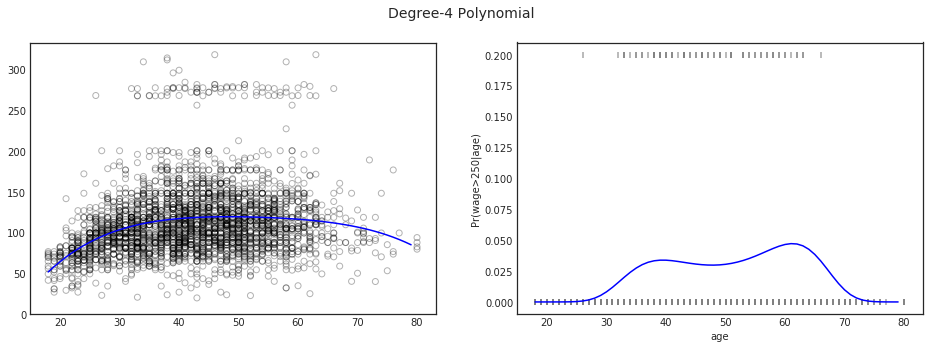

In [39]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred1, color = 'b')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred2, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

### Deciding on a degree

In performing a polynomial regression we must decide on the degree of the polynomial to use. One way to do this is by using hypothesis tests. We now fit models ranging from linear to a degree-5 polynomial and seek to determine the simplest model which is sufficient to explain the relationship between wage and age.

We can do this using the anova_lm() function, which performs an analysis of variance (ANOVA, using an F-test) in order to test the null hypothesis that a model  M1  is sufficient to explain the data against the alternative hypothesis that a more complex model  M2  is required. In order to use the anova_lm() function,  M1  and  M2  must be nested models: the predictors in  M1  must be a subset of the predictors in  M2 . In this case, we fit five different models and sequentially compare the simpler model to the more complex model (Note: you may get an invalid value Runtime Warning on the first model, because there is no "simpler model" to compare to):

In [41]:
fit_1 = fit = sm.GLS(df.wage, X1).fit()
fit_2 = fit = sm.GLS(df.wage, X2).fit()
fit_3 = fit = sm.GLS(df.wage, X3).fit()
fit_4 = fit = sm.GLS(df.wage, X4).fit()
fit_5 = fit = sm.GLS(df.wage, X5).fit()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")  ## Supress warnings
    display(sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


The  p -value comparing the linear Model 1 to the quadratic Model 2 is essentially zero  ($<10^{−32}$) , indicating that a linear fit is not sufficient. Similarly the  p -value comparing the quadratic Model 2 to the cubic Model 3 is very low (0.0017), so the quadratic fit is also insufficient. The  p -value comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is approximately 0.05 while the degree-5 polynomial Model 5 seems unnecessary because its  p -value is 0.37. Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, but lower- or higher-order models are not justified.

As an alternative to using hypothesis tests and ANOVA, we could choose the polynomial degree using cross-validation as we have in previous labs.

## Step functions

To fit a step function, we use the cut() function

In [42]:
df_cut, bins = pd.cut(df.age, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

Here cut() automatically picked the cutpoints at 33.5, 49, and 64.5 years of age. We could also have specified our own cutpoints directly. Now let's create a set of dummy variables for use in the regression:

In [43]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys = ['age','age_cuts','wage'], axis = 1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

# Drop the (17.938, 33.5] category
df_steps_dummies = df_steps_dummies.drop(df_steps_dummies.columns[1], axis = 1)

df_steps_dummies.head(5)

,const,"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
231655,1.0,0,0,0
86582,1.0,0,0,0
161300,1.0,1,0,0
155159,1.0,1,0,0
11443,1.0,0,1,0


And now to fit the models! We dropped the age<33.5 category, so the intercept coefficient of $94,160 can be interpreted as the average salary for those under 33.5 years of age. The other coefficients can be interpreted as the average additional salary for those in the other age groups.

In [44]:
fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()
fit3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416


We can produce predictions and plots just as we did in the case of the polynomial fit.

Text(0.5, 0, 'age')

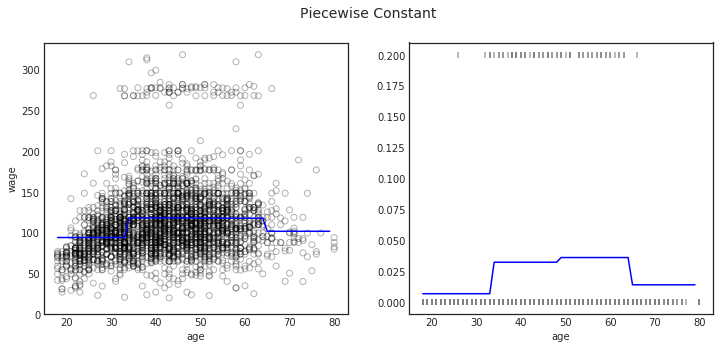

In [46]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)

# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis = 1))

# Predict the value of the generated ages using the linear model
pred2 = fit3.predict(X_test2)

# And the logistic model
clf2 = sm.GLM(y, df_steps_dummies,
              family=sm.families.Binomial())
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

# Plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
fig.suptitle('Piecewise Constant', fontsize = 14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor = 'None', edgecolor = 'k', alpha = 0.3)
ax1.plot(age_grid, pred2, c = 'b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin = 0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color = 'b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s = 30, c = 'grey', marker = '|', alpha = 0.7)

ax2.set_ylim(-0.01, 0.21)
ax2.set_xlabel('age')

<a id='lab_7.8.2'></a>
## Lab 7.8.2 Splines

### JLiu method (based on JRouser lab, but less details)
Cubic splines

In [22]:
# Specifying 3 knots
transformed_3knots = dmatrix("bs(wage.age, knots=(25,40,60), degree=3, include_intercept=False)",
                         {"wage.age": wage.age}, return_type='dataframe')

# Build a regular linear model from the splines
spln_3knots = sm.GLM(wage.wage, transformed_3knots).fit()
pred_3knots = spln_3knots.predict(dmatrix("bs(age_grid, knots=(25,40,60), degree=3, include_intercept=False)",
                                          {"age_grid": age_grid}, return_type='dataframe'))
spln_3knots.params

Intercept                                                                 60.493714
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

In [23]:
# Specifying 6 degrees of freedom 
transformed_deg6 = dmatrix("bs(wage.age, df=6, include_intercept=False)",
                        {"wage.age": wage.age}, return_type='dataframe')
spln_deg6 = sm.GLM(wage.wage, transformed_deg6).fit()
pred_deg6 = spln_deg6.predict(dmatrix("bs(age_grid, df=6, degree=3, include_intercept=False)",
                                  {"age_grid": age_grid}, return_type='dataframe'))
spln_deg6.params

Intercept                                         56.313841
bs(wage.age, df=6, include_intercept=False)[0]    27.824002
bs(wage.age, df=6, include_intercept=False)[1]    54.062546
bs(wage.age, df=6, include_intercept=False)[2]    65.828391
bs(wage.age, df=6, include_intercept=False)[3]    55.812734
bs(wage.age, df=6, include_intercept=False)[4]    72.131473
bs(wage.age, df=6, include_intercept=False)[5]    14.750876
dtype: float64

**Natural splines**

In [24]:
# Specifying 4 degrees of freedom
transformed_deg4 = dmatrix("cr(wage.age, df=4)", {"wage.age": wage.age}, return_type='dataframe')
spln_deg4 = sm.GLM(wage.wage, transformed_deg4).fit()
pred_deg4 = spln_deg4.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))
spln_deg4.params

Intercept                79.642095
cr(wage.age, df=4)[0]   -14.667784
cr(wage.age, df=4)[1]    36.811142
cr(wage.age, df=4)[2]    35.934874
cr(wage.age, df=4)[3]    21.563863
dtype: float64

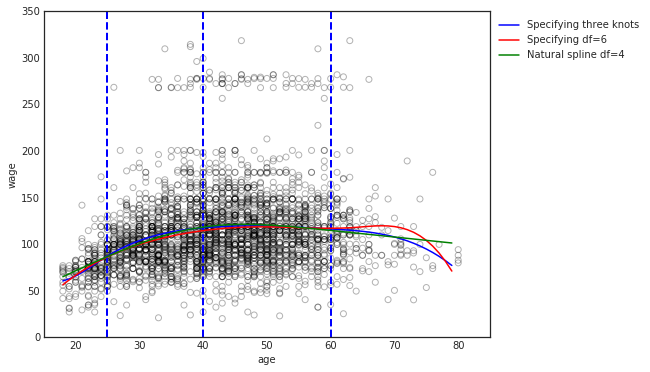

In [56]:
# Plot splines
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(wage.age, wage.wage, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(age_grid, pred_3knots, color='b', label='Specifying three knots')
plt.plot(age_grid, pred_deg6, color='r', label='Specifying df=6')
plt.plot(age_grid, pred_deg4, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage');

<a id='jr_splines'></a>
## JRouser: Splines

In [47]:
# Read in the data
df = pd.read_csv('Wage.csv')

# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

In order to fit regression splines in python, we use the **dmatrix** module from the **patsy** library. In lecture, we saw that regression splines can be fit by constructing an appropriate matrix of basis functions. The  bs()  function generates the entire matrix of basis functions for splines with the specified set of knots. Fitting  wage  to  age  using a regression spline is simple:

In [50]:
# Specifying 3 knots
transformed_x1 = dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')

# Build a regular linear model from the splines
fit1 = sm.GLM(df.wage, transformed_x1).fit()
fit1.params

Intercept                                                               60.493714
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

Here we have prespecified knots at ages 25, 40, and 60. This produces a spline with six basis functions. (Recall that a cubic spline with three knots has seven degrees of freedom; these degrees of freedom are used up by an intercept, plus six basis functions.) We could also use the  df  option to produce a spline with knots at uniform quantiles of the data:

In [51]:
# Specifying 6 degrees of freedom 
transformed_x2 = dmatrix("bs(df.age, df=6, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit2 = sm.GLM(df.wage, transformed_x2).fit()
fit2.params

Intercept                                       56.313841
bs(df.age, df=6, include_intercept=False)[0]    27.824002
bs(df.age, df=6, include_intercept=False)[1]    54.062546
bs(df.age, df=6, include_intercept=False)[2]    65.828391
bs(df.age, df=6, include_intercept=False)[3]    55.812734
bs(df.age, df=6, include_intercept=False)[4]    72.131473
bs(df.age, df=6, include_intercept=False)[5]    14.750876
dtype: float64

In this case python chooses knots which correspond to the 25th, 50th, and 75th percentiles of  age . The function  bs()  also has a  degree  argument, *df*, so we can fit splines of any degree, rather than the default degree of 3 (which yields a cubic spline).

In order to instead fit a natural spline, we use the  cr()  function. Here we fit a natural spline with four degrees of freedom:

In [53]:
# Specifying 4 degrees of freedom
transformed_x3 = dmatrix("cr(df.age, df=4)", {"df.age": df.age}, return_type='dataframe')
fit3 = sm.GLM(df.wage, transformed_x3).fit()
fit3.params

Intercept              79.642095
cr(df.age, df=4)[0]   -14.667784
cr(df.age, df=4)[1]    36.811142
cr(df.age, df=4)[2]    35.934874
cr(df.age, df=4)[3]    21.563863
dtype: float64

As with the **bs()** function, we could instead specify the knots directly using the *knots* option.

Let's see how these three models stack up:

Text(0, 0.5, 'wage')

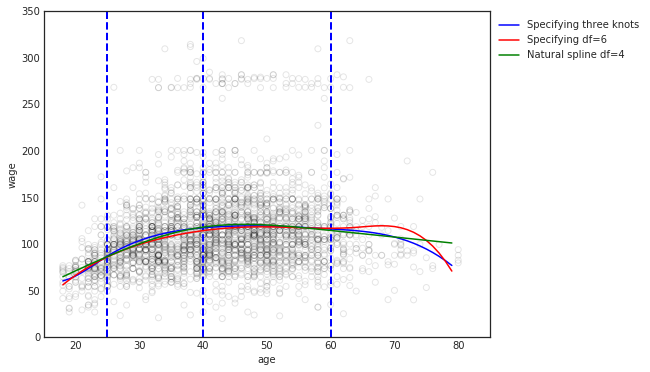

In [57]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(age_grid, knots=(25,40,60), include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(age_grid, df=6, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
pred3 = fit3.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))

# Plot the splines and error bands
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred1, color='b', label='Specifying three knots')
plt.plot(age_grid, pred2, color='r', label='Specifying df=6')
plt.plot(age_grid, pred3, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')

<a id='lab_7.8.3'></a>
## Lab 7.8.3 GAMs

### JLiu method 

<a id ='concept'></a>
## Conceptual Exercises

Taken from: https://blog.princehonest.com/stat-learning/

1) 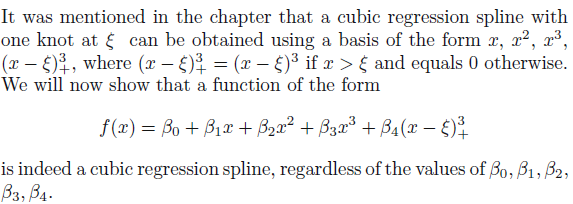

1b) For a cubic regression with **one** knot

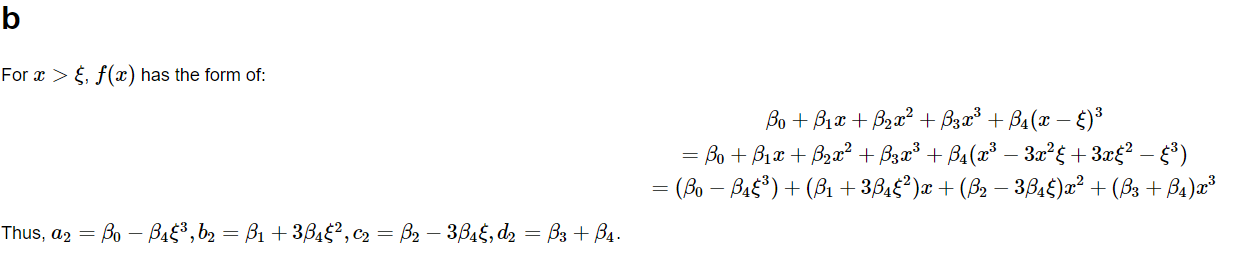

1 c,d) These questions show that f1 (function before the knot) and f2 (function after the knot) are equal, in other words the curve is continuous. The first and second derivative of f1 and f2 are also equal which means that the curves are continuous. 

2) This question is about smoothing splines and the equation:
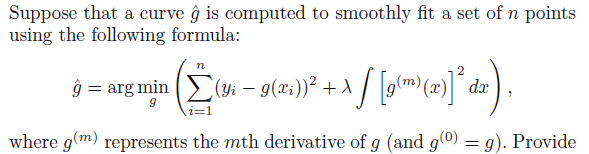

2a) g(x)=k because RSS term is ignored and g(x)=k would minimize the area under the curve of g(0).

2b) $g(x)\alpha x^2$. g(x) would be quadratic to minimize the area under the curve of its first derivative.

2c) $g(x)\alpha x^3$. g(x) would be cubic to minimize the area under the curve of its second derivative. See Eqn 7.11.

2d)  $g(x)\alpha x^4$. g(x) would be quartic to minimize the area under the curve of its third derivative.

2e) The penalty term no longer matters. Without the penalty term, equation becomes linear regression formula.

5) This question is also about smoothing splines. see equation in question 2 above. g1 has m = 3 while g2 has m = 4.

5a) As $\lambda$ goes to $\infty$, the training RSS of g2 will be be smaller because it will be a higher order polynomial due to the order of the derivative penalty function.

5b) As $\lambda$ goes to $\infty$, the test RSS of g1 is expected to be smaller because g2 could overfit with the extra degree of freedom.

5c) Trick question. g1 = g2 when $\lambda = 0$